In [1]:
import sys, os
from pathlib import Path
import random
from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot as plt
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

sys.path.append("..")
from src.foe_conv_net import FOEConvNet
from src.foe_autoencoder import Encoder, Decoder
from src.foe_mlp import FOEMLP
from src.foe_utils import *

keys = []
types = []
confs = []

VALIDATION_BATCH_SIZE = 256
NUM_WORKERS = 4
FOLD_IDX = 0

with open("args.yml") as f:
    args = yaml.safe_load(f)

args = SimpleNamespace(**args)

base_path = Path(args.base_path)
n_epochs = args.n_epochs
batch_size = args.batch_size
learning_rate = args.learning_rate

use_gpu = torch.cuda.is_available() and not args.cpu
device = 'cuda' if use_gpu else 'cpu'
print("Using {}...".format(device))

if args.seed is not None:
    seed = int(args.seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)

output_path = Path(args.output_dir)
output_path.mkdir(parents=True, exist_ok=True)
model_dir = output_path.joinpath('models')
model_dir.mkdir(parents=True, exist_ok=True)

# log_dir = output_path.joinpath('log/foe')
# tb_writer = SummaryWriter(log_dir=log_dir)

# load fingerprint data
good_path = (base_path.joinpath('Good'), True)
fp_paths = [good_path]
if not args.without_bad:
    bad_path = base_path.joinpath('Bad')
    fp_paths.append((bad_path, False))
    
tset, vset, model = init_model_and_datasets(fp_paths, args.n_classes,
                                            args.patch_size,
                                            args.n_folds, FOLD_IDX,
                                            args.model_path,
                                            args.no_shuffle,
                                            args.verbose)

# Data augmentation parameters
if not args.no_hflip:
    tset.set_hflip(True)
if args.delta_r > 0.0:
    tset.set_delta_r(args.delta_r)

# initialize loader, model, and other training machinary
train_loader = DataLoader(tset,
                            batch_size=batch_size,
                            num_workers=NUM_WORKERS,
                            shuffle=True,
                            pin_memory=use_gpu)
val_loader = DataLoader(vset,
                        batch_size=VALIDATION_BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=True,
                        pin_memory=use_gpu)

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(),
                        lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                            [int(0.4 * n_epochs),
                                            int(0.75 * n_epochs)],
                                            gamma=0.1)

n_train = len(train_loader.dataset)
n_val = len(val_loader.dataset)
print("""Number of classes: {}
Patch size: {}
Batch size: {}
Rotation delta: {:.1f}°
Training set size: {}
Validation set size: {}""".format(model.n_classes, model.patch_size,
                                batch_size,
                                args.delta_r * 180.0 / np.pi,
                                n_train, n_val))

Using cuda...


Loaded 10 fingerprints.
Randomized splits.


Number of classes: 2
Patch size: 32
Batch size: 128
Rotation delta: 5.7°
Training set size: 17525
Validation set size: 1421


In [2]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, y, theta in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
#         print(decoded_data[0].min().item(), decoded_data[0].max().item(), image_batch[0].min().item(), image_batch[0].max().item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_img = []
        for image_batch, y, theta in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_img.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_img = torch.cat(conc_img) 
        val_loss = loss_fn(conc_out, conc_img)
    return val_loss.data

def find_lr(device, train_loader, loss_fn, init_value = 1e-2, final_value=1e3, beta=0.98, mult=1.1):
    lr = init_value
    avg_loss = 0.
    best_loss = 0.
    losses = []
    log_lrs = []
    num = int(np.log(final_value / init_value) / np.log(mult))+1
    for i in range(1,num+1):
        print(i, num)
        encoded_space_dim = 256
        encoder = Encoder(encoded_space_dim)
        decoder = Decoder(encoded_space_dim)
        params_to_optimize = [
            {'params': encoder.parameters()},
            {'params': decoder.parameters()}
        ]

        # Move both the encoder and the decoder to the selected device
        encoder.to(device)
        decoder.to(device)
        optimizer = optim.Adam(params_to_optimize, lr=lr)
    
        loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optimizer)
        avg_loss = beta * avg_loss + (1-beta) *loss
        smoothed_loss = avg_loss / (1 - beta**i)
        #Stop if the loss is exploding
        if i > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or i==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(loss)
        log_lrs.append(np.log10(lr))
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    plt.ion()
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = vset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [3]:
# loss_fn = torch.nn.MSELoss()

# logs,losses = find_lr(device, train_loader,loss_fn)
# plt.figure(figsize=(10,8))
# plt.plot(logs,losses)
# print(logs, losses)

EPOCH 1/200 	 train loss 0.053573790937662125 	 val loss 0.019189592450857162


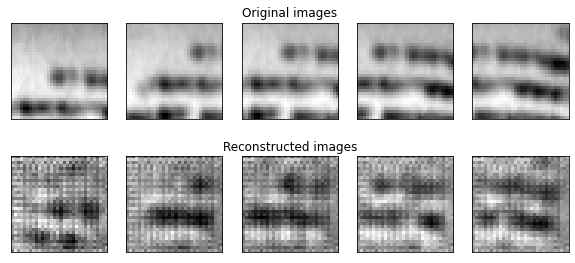

EPOCH 2/200 	 train loss 0.017008135095238686 	 val loss 0.01267752330750227
EPOCH 3/200 	 train loss 0.013560489751398563 	 val loss 0.010996765457093716
EPOCH 4/200 	 train loss 0.012184752151370049 	 val loss 0.010157141834497452
EPOCH 5/200 	 train loss 0.011644267477095127 	 val loss 0.00974952057003975
EPOCH 6/200 	 train loss 0.011148960329592228 	 val loss 0.009243660606443882
EPOCH 7/200 	 train loss 0.010732623748481274 	 val loss 0.008925660513341427
EPOCH 8/200 	 train loss 0.010412024334073067 	 val loss 0.008739328943192959
EPOCH 9/200 	 train loss 0.010236377827823162 	 val loss 0.008635495789349079
EPOCH 10/200 	 train loss 0.010138850659132004 	 val loss 0.008619976229965687
EPOCH 11/200 	 train loss 0.010045301169157028 	 val loss 0.008294948376715183
EPOCH 12/200 	 train loss 0.009944751858711243 	 val loss 0.008272477425634861
EPOCH 13/200 	 train loss 0.009908484295010567 	 val loss 0.008273963816463947
EPOCH 14/200 	 train loss 0.009890669025480747 	 val loss 0.00

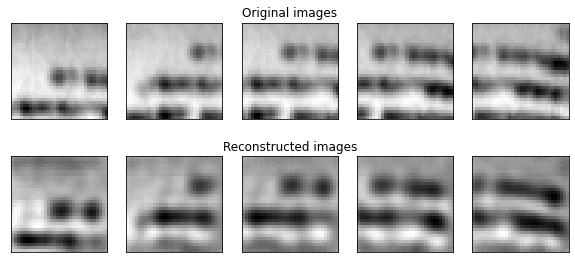

EPOCH 22/200 	 train loss 0.009744319133460522 	 val loss 0.008140920661389828
EPOCH 23/200 	 train loss 0.009747070260345936 	 val loss 0.008146479725837708
EPOCH 24/200 	 train loss 0.009754414670169353 	 val loss 0.008227437734603882
EPOCH 25/200 	 train loss 0.009708810597658157 	 val loss 0.008134936913847923
EPOCH 26/200 	 train loss 0.009714263491332531 	 val loss 0.008175169117748737
EPOCH 27/200 	 train loss 0.009712103754281998 	 val loss 0.008092986419796944
EPOCH 28/200 	 train loss 0.009734670631587505 	 val loss 0.00818757526576519
EPOCH 29/200 	 train loss 0.009716879576444626 	 val loss 0.008145453408360481
EPOCH 30/200 	 train loss 0.009720922447741032 	 val loss 0.00813409686088562
EPOCH 31/200 	 train loss 0.00966189056634903 	 val loss 0.008146754465997219
EPOCH 32/200 	 train loss 0.009681367315351963 	 val loss 0.008180459961295128
EPOCH 33/200 	 train loss 0.009704850614070892 	 val loss 0.00817101076245308
EPOCH 34/200 	 train loss 0.00965570192784071 	 val loss

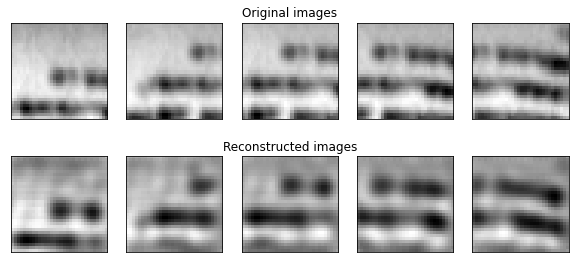

EPOCH 42/200 	 train loss 0.009635058231651783 	 val loss 0.008198927156627178
EPOCH 43/200 	 train loss 0.00963258184492588 	 val loss 0.008084476925432682
EPOCH 44/200 	 train loss 0.00958951748907566 	 val loss 0.008077774196863174
EPOCH 45/200 	 train loss 0.009594228118658066 	 val loss 0.008047381415963173
EPOCH 46/200 	 train loss 0.009600505232810974 	 val loss 0.008067271672189236
EPOCH 47/200 	 train loss 0.0096124317497015 	 val loss 0.008156185038387775
EPOCH 48/200 	 train loss 0.009624923579394817 	 val loss 0.008062383159995079
EPOCH 49/200 	 train loss 0.009596509858965874 	 val loss 0.008111313916742802
EPOCH 50/200 	 train loss 0.009604111313819885 	 val loss 0.008144165389239788
EPOCH 51/200 	 train loss 0.009603741578757763 	 val loss 0.008035857230424881
EPOCH 52/200 	 train loss 0.009586142376065254 	 val loss 0.00806348491460085
EPOCH 53/200 	 train loss 0.009581525810062885 	 val loss 0.008073901757597923
EPOCH 54/200 	 train loss 0.009586865082383156 	 val loss

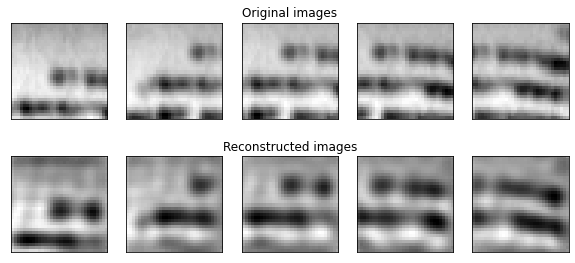

EPOCH 62/200 	 train loss 0.009557954035699368 	 val loss 0.007998994551599026
EPOCH 63/200 	 train loss 0.009554839693009853 	 val loss 0.008061781525611877
EPOCH 64/200 	 train loss 0.009543594904243946 	 val loss 0.008005371317267418
EPOCH 65/200 	 train loss 0.00955088809132576 	 val loss 0.008016926236450672
EPOCH 66/200 	 train loss 0.009547035209834576 	 val loss 0.008074862882494926
EPOCH 67/200 	 train loss 0.009541523642838001 	 val loss 0.007950915023684502
EPOCH 68/200 	 train loss 0.009529017843306065 	 val loss 0.008018670603632927
EPOCH 69/200 	 train loss 0.009531618095934391 	 val loss 0.008022038266062737
EPOCH 70/200 	 train loss 0.009535238146781921 	 val loss 0.00802470650523901
EPOCH 71/200 	 train loss 0.009533998556435108 	 val loss 0.008033023215830326
EPOCH 72/200 	 train loss 0.009535279124975204 	 val loss 0.007966919802129269
EPOCH 73/200 	 train loss 0.009521173313260078 	 val loss 0.008030765689909458
EPOCH 74/200 	 train loss 0.00951296929270029 	 val lo

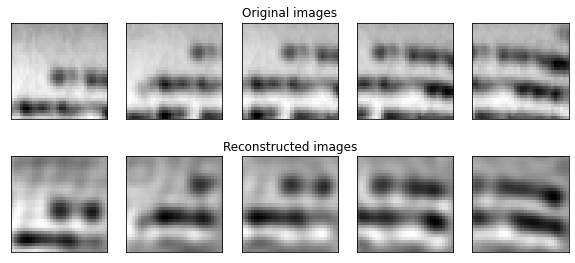

EPOCH 82/200 	 train loss 0.009520040825009346 	 val loss 0.007952379062771797
EPOCH 83/200 	 train loss 0.00952661968767643 	 val loss 0.007999145425856113
EPOCH 84/200 	 train loss 0.009515151381492615 	 val loss 0.00802568905055523
EPOCH 85/200 	 train loss 0.009510298259556293 	 val loss 0.007960635237395763
EPOCH 86/200 	 train loss 0.009506351314485073 	 val loss 0.008081149309873581
EPOCH 87/200 	 train loss 0.009505685418844223 	 val loss 0.007948757149279118
EPOCH 88/200 	 train loss 0.009502628818154335 	 val loss 0.007975396700203419
EPOCH 89/200 	 train loss 0.009499737992882729 	 val loss 0.00798879750072956
EPOCH 90/200 	 train loss 0.00951495673507452 	 val loss 0.008025174960494041
EPOCH 91/200 	 train loss 0.009510405361652374 	 val loss 0.008045616559684277
EPOCH 92/200 	 train loss 0.009519405663013458 	 val loss 0.008001904934644699
EPOCH 93/200 	 train loss 0.009510725736618042 	 val loss 0.008040285669267178
EPOCH 94/200 	 train loss 0.009477403946220875 	 val los

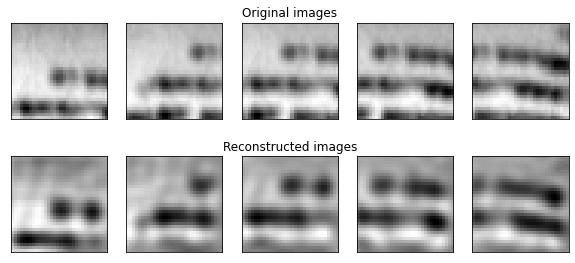

EPOCH 102/200 	 train loss 0.009489485062658787 	 val loss 0.007941651158034801
EPOCH 103/200 	 train loss 0.00947854109108448 	 val loss 0.007968046702444553
EPOCH 104/200 	 train loss 0.00947645679116249 	 val loss 0.008005527779459953
EPOCH 105/200 	 train loss 0.00948452576994896 	 val loss 0.008019189350306988
EPOCH 106/200 	 train loss 0.009474942460656166 	 val loss 0.007997835986316204
EPOCH 107/200 	 train loss 0.009470845572650433 	 val loss 0.0079811941832304
EPOCH 108/200 	 train loss 0.009490465745329857 	 val loss 0.007960912771522999
EPOCH 109/200 	 train loss 0.009479153901338577 	 val loss 0.007996371015906334
EPOCH 110/200 	 train loss 0.009473630227148533 	 val loss 0.008032133802771568
EPOCH 111/200 	 train loss 0.009474501013755798 	 val loss 0.007994160056114197
EPOCH 112/200 	 train loss 0.009466176852583885 	 val loss 0.007915619760751724
EPOCH 113/200 	 train loss 0.009464005939662457 	 val loss 0.00795439537614584
EPOCH 114/200 	 train loss 0.00947599671781063

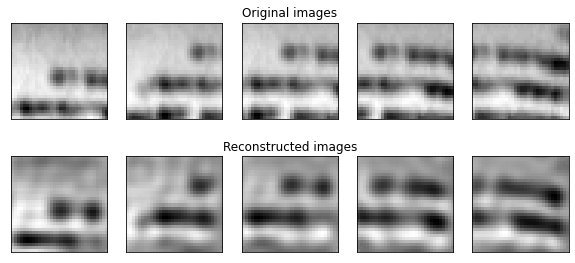

EPOCH 122/200 	 train loss 0.009457379579544067 	 val loss 0.00799932237714529
EPOCH 123/200 	 train loss 0.009476968087255955 	 val loss 0.008014089427888393
EPOCH 124/200 	 train loss 0.009457544423639774 	 val loss 0.007996008731424809
EPOCH 125/200 	 train loss 0.009463740512728691 	 val loss 0.008035329170525074
EPOCH 126/200 	 train loss 0.009454382583498955 	 val loss 0.007937856949865818
EPOCH 127/200 	 train loss 0.009446770884096622 	 val loss 0.00796155072748661
EPOCH 128/200 	 train loss 0.009456143714487553 	 val loss 0.007973411120474339
EPOCH 129/200 	 train loss 0.009449929930269718 	 val loss 0.007972966879606247
EPOCH 130/200 	 train loss 0.00946379080414772 	 val loss 0.007999350316822529
EPOCH 131/200 	 train loss 0.009422401897609234 	 val loss 0.007953925989568233
EPOCH 132/200 	 train loss 0.009440399706363678 	 val loss 0.007950293831527233
EPOCH 133/200 	 train loss 0.009455660358071327 	 val loss 0.007954000495374203
EPOCH 134/200 	 train loss 0.00946928467601

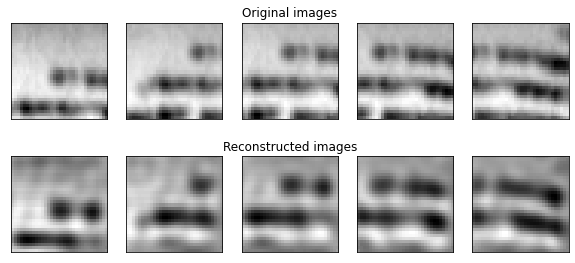

EPOCH 142/200 	 train loss 0.00946227740496397 	 val loss 0.007974743843078613
EPOCH 143/200 	 train loss 0.009445837698876858 	 val loss 0.00796427857130766
EPOCH 144/200 	 train loss 0.009439934976398945 	 val loss 0.007959549315273762
EPOCH 145/200 	 train loss 0.00944146141409874 	 val loss 0.00797291100025177
EPOCH 146/200 	 train loss 0.00943244993686676 	 val loss 0.00798202957957983
EPOCH 147/200 	 train loss 0.009447024203836918 	 val loss 0.007970965467393398
EPOCH 148/200 	 train loss 0.009441391564905643 	 val loss 0.007962130941450596
EPOCH 149/200 	 train loss 0.009434717707335949 	 val loss 0.007943068630993366
EPOCH 150/200 	 train loss 0.00944153405725956 	 val loss 0.008017852902412415
EPOCH 151/200 	 train loss 0.009454424493014812 	 val loss 0.007965626195073128
EPOCH 152/200 	 train loss 0.009452038444578648 	 val loss 0.007962392643094063
EPOCH 153/200 	 train loss 0.009447388350963593 	 val loss 0.00794998649507761
EPOCH 154/200 	 train loss 0.009442309848964214 

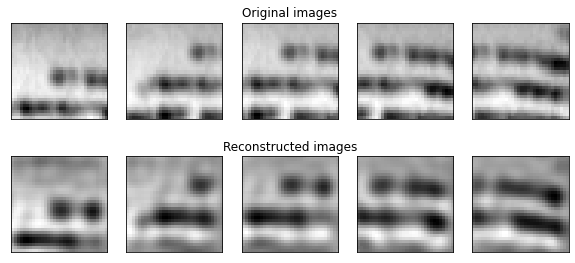

EPOCH 162/200 	 train loss 0.009440217167139053 	 val loss 0.008015141822397709
EPOCH 163/200 	 train loss 0.009438293986022472 	 val loss 0.007965733297169209
EPOCH 164/200 	 train loss 0.009418726898729801 	 val loss 0.008015387691557407
EPOCH 165/200 	 train loss 0.009425566531717777 	 val loss 0.008000856265425682
EPOCH 166/200 	 train loss 0.009437303058803082 	 val loss 0.008010978810489178
EPOCH 167/200 	 train loss 0.009433276019990444 	 val loss 0.007968866266310215
EPOCH 168/200 	 train loss 0.00942243356257677 	 val loss 0.007943385280668736
EPOCH 169/200 	 train loss 0.009442856535315514 	 val loss 0.007994958199560642
EPOCH 170/200 	 train loss 0.009418758563697338 	 val loss 0.007946623489260674
EPOCH 171/200 	 train loss 0.00943449791520834 	 val loss 0.00800288189202547
EPOCH 172/200 	 train loss 0.00942016951739788 	 val loss 0.007964635267853737
EPOCH 173/200 	 train loss 0.009436443448066711 	 val loss 0.007977700792253017
EPOCH 174/200 	 train loss 0.009418331086635

KeyboardInterrupt: 

In [4]:
encoded_space_dim = 64
encoder = Encoder(encoded_space_dim).to(device)
decoder = Decoder(encoded_space_dim).to(device)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optimizer = optim.Adam(params_to_optimize, lr=learning_rate/10)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                           [int(0.50 * n_epochs)],
                                           gamma=0.1)

# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=n_epochs)
loss_fn = torch.nn.MSELoss()
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(n_epochs):
    train_loss = train_epoch(encoder,decoder,device, train_loader,loss_fn,optimizer)
    val_loss = val_epoch(encoder,decoder,device,val_loader,loss_fn)
    print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, n_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    # Plot losses
    if epoch%20 == 0:
        plot_ae_outputs(encoder,decoder,n=5)

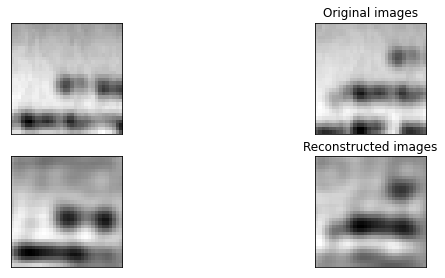

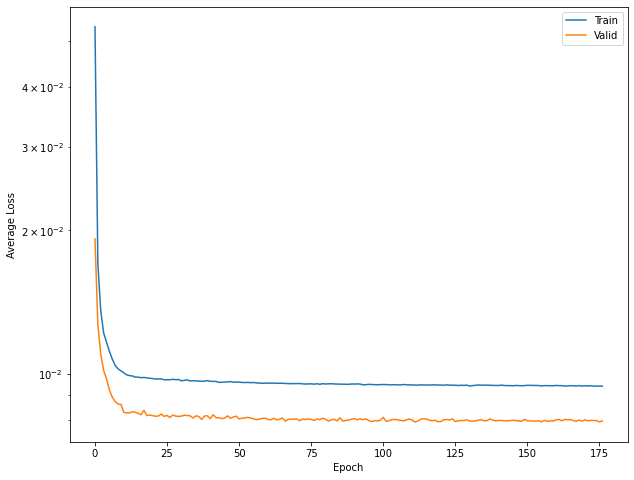

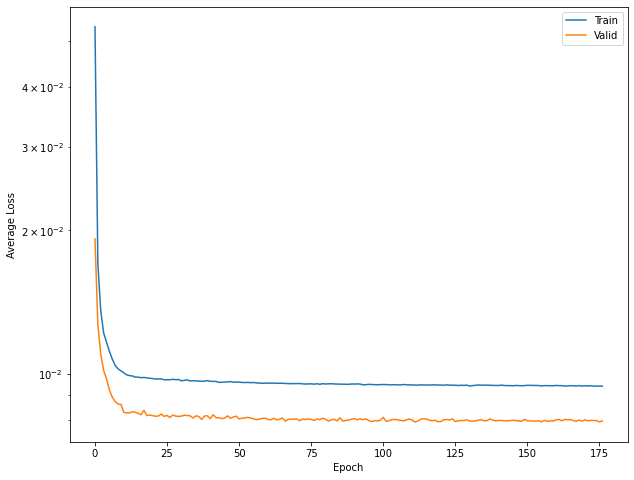

In [5]:
plot_ae_outputs(encoder,decoder,n=2)

plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show() 

In [6]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    train_err_sqr = 0.0
    n_train_batches = 0
    for idx, (x, y, theta) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        x = encoder(x)
        optimizer.zero_grad()
        ye = model(x)
    
        loss = criterion(ye, y.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        theta_estimated = np.arctan2(ye[:,0].cpu().detach().numpy(),ye[:,1].cpu().detach().numpy())
        train_err_sqr += FOEOrientation.estimation_error_sqr(theta, theta_estimated)
        n_train_batches += 1

    return train_loss / n_train_batches, train_err_sqr
def validate_model(model, val_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_err_sqr = 0.0
        n_val_batches = 0
        for x, y, theta in val_loader:
            x, y = x.to(device), y.to(device)
            x = encoder(x)
            ye = model(x)
            val_loss += criterion(ye, y).item()
            theta_estimated = np.arctan2(ye[:,0].cpu().detach().numpy(),ye[:,1].cpu().detach().numpy())
            val_err_sqr += FOEOrientation.estimation_error_sqr(theta, theta_estimated)
            
            n_val_batches += 1
        
        return val_loss / n_val_batches, val_err_sqr

In [8]:
model = FOEMLP(encoded_space_dim).to(device)
criterion = torch.nn.MSELoss().to(device)

optimizer = optim.Adam(model.parameters(),
                       lr=0.001)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
#                                            [int(0.25 * n_epochs),
#                                             int(0.50 * n_epochs),
#                                             int(0.75 * n_epochs)],
#                                            gamma=0.1)

# run training + validation for each epoch
train_res = []
val_res = []
for e in range(n_epochs):
    train_loss, train_err_sqr = train_model(model, train_loader, optimizer, criterion, device)
    train_rmse = np.sqrt(train_err_sqr / n_train) * 180.0 / np.pi  # in degrees
    train_res.append([train_loss, train_rmse])

    val_loss, val_err_sqr = validate_model(model, val_loader, criterion, device)
    val_rmse = np.sqrt(val_err_sqr / n_val) * 180.0 / np.pi  # in degrees
    val_res.append([val_loss, val_rmse])

    print('Epoch {}/{}: train loss / rmse = {:.4f} / {:.1f}° validation loss / rmse = {:.4f} / {:.1f}°'
          .format(e+1, n_epochs, train_loss, train_rmse, val_loss, val_rmse))
    
#     scheduler.step()


Epoch 1/200: train loss / rmse = 0.3650 / 56.4° validation loss / rmse = 0.2865 / 50.7°
Epoch 2/200: train loss / rmse = 0.3122 / 53.3° validation loss / rmse = 0.2887 / 50.7°
Epoch 3/200: train loss / rmse = 0.3109 / 53.5° validation loss / rmse = 0.2864 / 51.1°
Epoch 4/200: train loss / rmse = 0.3094 / 53.4° validation loss / rmse = 0.2853 / 51.0°
Epoch 5/200: train loss / rmse = 0.3085 / 53.5° validation loss / rmse = 0.2836 / 50.5°
Epoch 6/200: train loss / rmse = 0.3078 / 53.2° validation loss / rmse = 0.2832 / 50.6°
Epoch 7/200: train loss / rmse = 0.3077 / 53.2° validation loss / rmse = 0.2883 / 51.1°
Epoch 8/200: train loss / rmse = 0.3067 / 53.2° validation loss / rmse = 0.2859 / 50.9°
Epoch 9/200: train loss / rmse = 0.3065 / 53.3° validation loss / rmse = 0.2835 / 50.6°
Epoch 10/200: train loss / rmse = 0.3069 / 53.2° validation loss / rmse = 0.2854 / 50.6°
Epoch 11/200: train loss / rmse = 0.3059 / 53.2° validation loss / rmse = 0.2849 / 50.7°
Epoch 12/200: train loss / rms

KeyboardInterrupt: 

In [ ]:
model = FOEConvNet(args.patch_size, args.n_classes).to(device)
# criterion = nn.CrossEntropyLoss().to(device)
criterion = torch.nn.MSELoss().to(device)
# criterion = Orientation_Loss()

optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                           [int(0.25 * n_epochs),
                                            int(0.50 * n_epochs),
                                            int(0.75 * n_epochs)],
                                           gamma=0.1)



class Orientation_Loss(torch.nn.Module):
    def __init__(self):
        super(Orientation_Loss,self).__init__()
        
    def forward(self, gt_in_radians, est_in_radians):
        deltas = gt_in_radians - est_in_radians
        deltas[deltas > np.pi/2.0] = np.pi - deltas[deltas > np.pi/2.0]
        delta_sqr = deltas ** 2
        totloss = torch.mean(delta_sqr)
        return totloss

# run training + validation for each epoch
train_res = []
val_res = []
for e in range(n_epochs):
    train_loss, train_err_sqr = train_model(model, train_loader, optimizer, criterion, device)
    train_rmse = np.sqrt(train_err_sqr / n_train) * 180.0 / np.pi  # in degrees
    train_res.append([train_loss, train_rmse])

    val_loss, val_err_sqr = validate_model(model, val_loader, criterion, device)
    val_rmse = np.sqrt(val_err_sqr / n_val) * 180.0 / np.pi  # in degrees
    val_res.append([val_loss, val_rmse])

    print('Epoch {}/{}: train loss / rmse = {:.4f} / {:.1f}° validation loss / rmse = {:.4f} / {:.1f}°'
          .format(e+1, n_epochs, train_loss, train_rmse, val_loss, val_rmse))
    
    scheduler.step()

    if e % 100 == 99:
        model_path = model_dir.joinpath('foe_conv_net_c{}_b{}_e{:04d}.pt'
                                        .format(args.n_classes, batch_size, n_epochs))
        torch.save(model.state_dict(), model_path)
        print('Saved model to {}'.format(model_path))

# save model also at the end
model_path = model_dir.joinpath('foe_conv_net_c{}_b{}_e{:04d}.pt'
                                .format(args.n_classes, batch_size, n_epochs))

torch.save(model.state_dict(), model_path)

In [ ]:
train_res = np.array(train_res)
val_res = np.array(val_res)

plt.figure()
plt.plot(train_res[:,0])
plt.plot(val_res[:,0])
plt.figure()
plt.plot(train_res[:,1])
plt.plot(val_res[:,1])

In [ ]:
for x, y, theta in val_loader:
#     print(x.shape, y.shape, theta.shape)
    print(y[0])
    print(theta[0]* 180.0 / np.pi)
    plt.figure()
    plt.imshow(x[0,0])